In [1]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload the zip file again
print("uploaded")


Saving archive (3).zip to archive (3).zip
uploaded


In [3]:
import zipfile
import os

# Correct file path
zip_path = "/content/archive (3).zip"

# Extract to a new folder
extract_path = "/content/dental_radiography"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extraction complete! Files are in: {extract_path}")


Extraction complete! Files are in: /content/dental_radiography


In [4]:
#import libraries
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [5]:
# Define the directories
data_dirs = [
    "/content/dental_radiography/train",
    "/content/dental_radiography/test",
    "/content/dental_radiography/valid"
]

# Iterate through each directory
for dir_path in data_dirs:
    print(f"Listing files in: {dir_path}")
    if os.path.exists(dir_path):
        files = os.listdir(dir_path)
        print(f"Total files: {len(files)}")
        #print(files[:5])  # Print first 5 files as a sample
    else:
        print("Directory not found!")
    print("-" * 50)


Listing files in: /content/dental_radiography/train
Total files: 1076
--------------------------------------------------
Listing files in: /content/dental_radiography/test
Total files: 74
--------------------------------------------------
Listing files in: /content/dental_radiography/valid
Total files: 122
--------------------------------------------------


In [6]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df_valid = pd.read_csv('/content/dental_radiography/valid/_annotations.csv')
#print(df_valid)
df_valid.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,186,85,209,129
1,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,167,93,188,128
2,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,143,93,170,130
3,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,127,132,155,182
4,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Implant,313,85,330,123


In [7]:
print(df_valid.loc[[0,1]]) #prints first and second row
print(df_valid.columns)
print(df_valid['class'].unique())


                                           filename  width  height     class  \
0  0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg    512     256  Fillings   
1  0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg    512     256  Fillings   

   xmin  ymin  xmax  ymax  
0   186    85   209   129  
1   167    93   188   128  
Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')
['Fillings' 'Implant' 'Impacted Tooth' 'Cavity']


In [8]:
import cv2

# Define the classes we are interested in:
target_classes = ['Fillings', 'Implant', 'Impacted Tooth', 'Cavity']

# Define dataset directories (adjust paths as needed)
dataset_dirs = [
    "/content/dental_radiography/train",
    "/content/dental_radiography/test",
    "/content/dental_radiography/valid"
]

# Define an output root directory for annotated images (writable in Kaggle)
output_root = '/kaggle/working/bbox_annotated'
if not os.path.exists(output_root):
    os.makedirs(output_root)

# (Optional) Define colors for each target class (BGR format for OpenCV)
colors = {
    'Fillings': (255, 0, 0),       # Blue
    'Implant': (0, 255, 0),        # Green
    'Impacted Tooth': (0, 0, 255), # Red
    'Cavity': (255, 255, 0)        # Cyan
}

# Process each dataset folder
for dset in dataset_dirs:
    # Use the base name (e.g., "train") for output folder naming
    dset_basename = os.path.basename(dset)
    print(f"Processing dataset: {dset_basename}")

    # Assume the annotations CSV file is named '_annotations.csv' in the folder
    annotation_path = os.path.join(dset, '_annotations.csv')
    df = pd.read_csv(annotation_path)

    # Create output directory for the annotated images for this dataset
    output_dset_folder = os.path.join(output_root, dset_basename)
    if not os.path.exists(output_dset_folder):
        os.makedirs(output_dset_folder)

    # Get the unique filenames from the annotations CSV
    unique_filenames = df['filename'].unique()

    for filename in unique_filenames:
        image_path = os.path.join(dset, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: could not read image {image_path}")
            continue

        # Get all annotation rows for the current image
        annots = df[df['filename'] == filename]

        # Loop over each annotation (bounding box) in this image
        for idx, row in annots.iterrows():
            # Convert coordinates to integers
            xmin, ymin = int(row['xmin']), int(row['ymin'])
            xmax, ymax = int(row['xmax']), int(row['ymax'])
            label = row['class']

            # Check that the label is in our target classes
            if label not in target_classes:
                continue

            # Validate bounding box coordinates (optional checks)
            img_height, img_width = image.shape[:2]
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                print(f"Skipping {filename}: bbox out of image bounds")
                continue
            if xmin >= xmax or ymin >= ymax:
                print(f"Skipping {filename}: invalid bbox coordinates")
                continue
            if (xmax - xmin) < 5 or (ymax - ymin) < 5:
                print(f"Skipping {filename}: bbox too small")
                continue

            # Draw the bounding box
            box_color = colors.get(label, (0, 255, 255))  # Default color if label not found
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), box_color, 2)
            # Optionally, add the label text above the box
            cv2.putText(image, label, (xmin, max(ymin - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, box_color, 2)

        # Save the annotated image to the output folder (use the original filename)
        save_path = os.path.join(output_dset_folder, filename)
        cv2.imwrite(save_path, image)

print("Bounding box annotation completed!")


Processing dataset: train
Skipping 0109_jpg.rf.e51226e7ad55c35a02d5dd6a45c6cede.jpg: bbox too small
Skipping 0812_jpg.rf.ea6f0c99e94cc51c5a17d6b32e05221a.jpg: bbox too small
Skipping 0974_jpg.rf.ff31d35aecfa18f7a3bb61736cb40dcf.jpg: invalid bbox coordinates
Skipping 0974_jpg.rf.08aa86b32941f04af43189a63b4f6683.jpg: invalid bbox coordinates
Skipping 0974_jpg.rf.1106191cfb2fa2d640fa75593eeb8122.jpg: invalid bbox coordinates
Skipping 0109_jpg.rf.7a0aba78a2e68e0014801c431fd3fa21.jpg: bbox too small
Skipping 0986_jpg.rf.4710f4b42773fdd8b5d2d715ca735dee.jpg: bbox too small
Skipping 0812_jpg.rf.4d617db1bddd307250bccd0db8797c50.jpg: bbox too small
Skipping 0986_jpg.rf.bd28c13ae802ca6d762e122c7711edd1.jpg: bbox too small
Skipping 0986_jpg.rf.c03ee1eb80e6fdb2d0bb8fa6d45f057e.jpg: bbox too small
Skipping 0812_jpg.rf.d21b197985af0893b59a89e9a231ca99.jpg: bbox too small
Processing dataset: test
Processing dataset: valid
Skipping 0835_jpg.rf.1c4c9ebcfee3d197b9e06fe7ad79713b.jpg: bbox too small
Bound

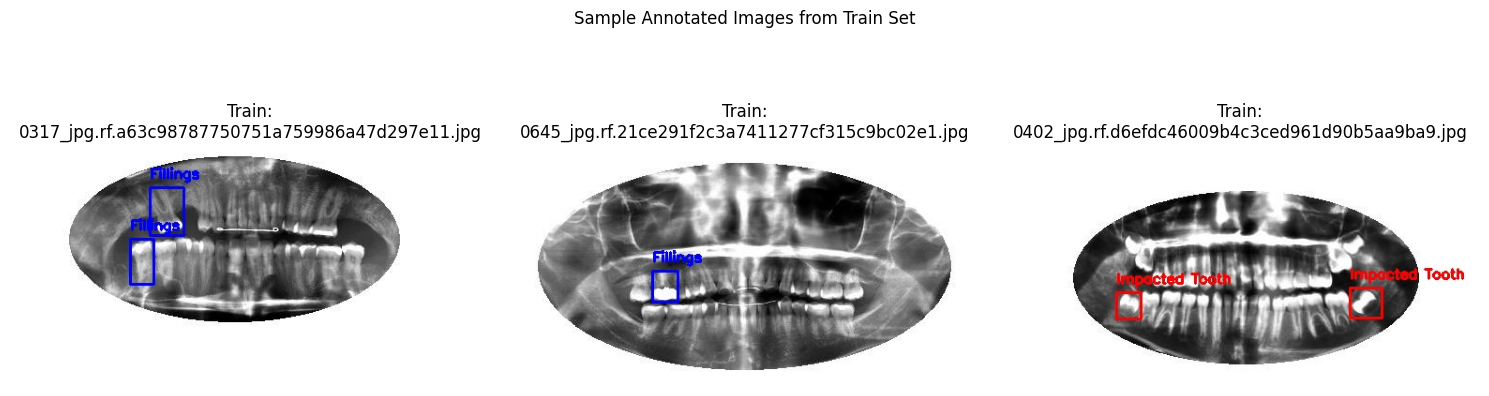

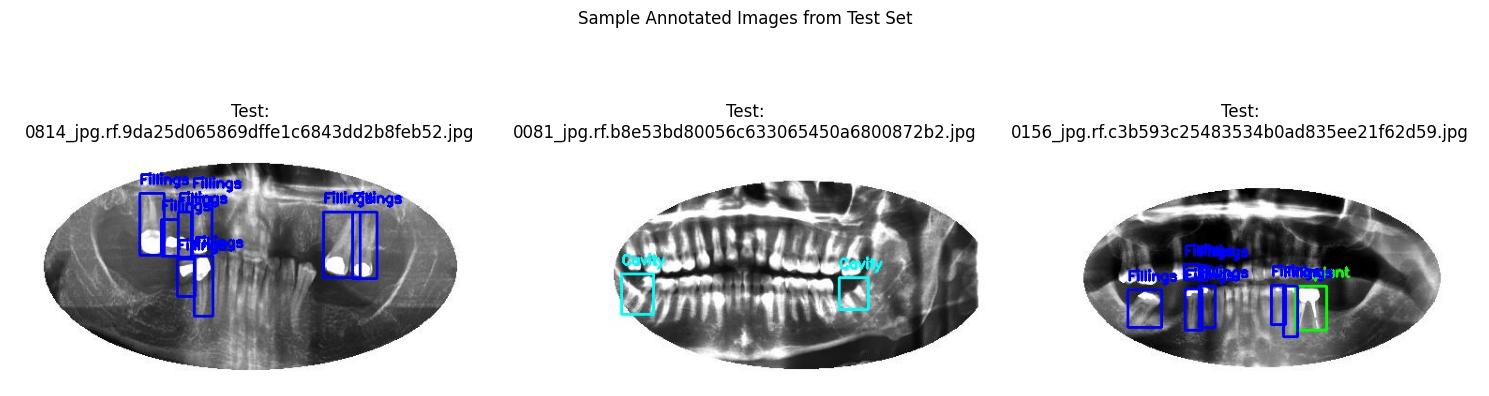

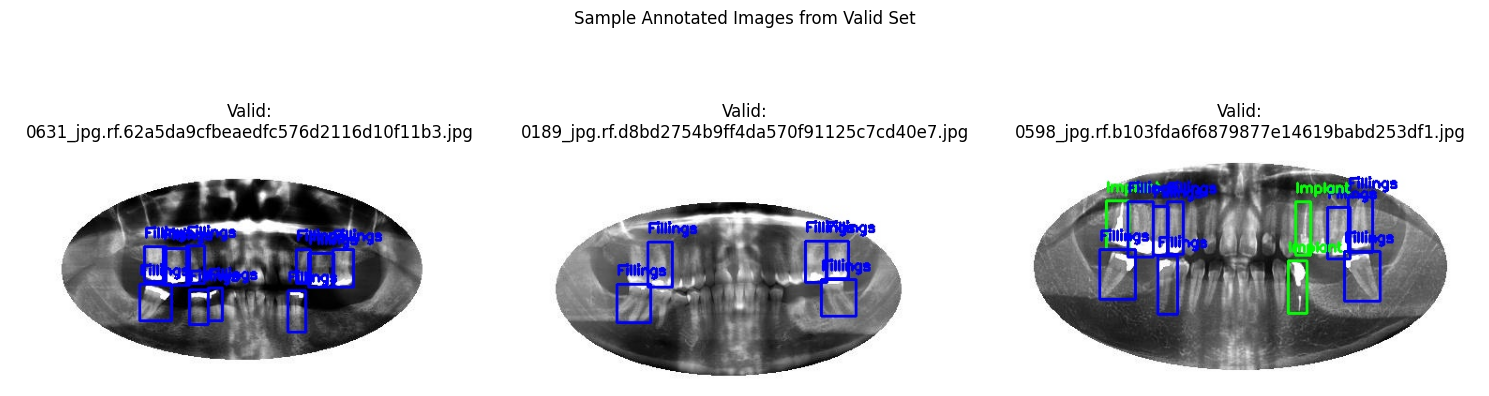

In [9]:
# --- Visualization ---
import matplotlib.pyplot as plt

# Define the output folder where annotated images are stored.
output_root = '/kaggle/working/bbox_annotated'
# List of dataset splits to visualize
dataset_splits = ['train', 'test', 'valid']

# Loop through each dataset folder and visualize a few images (e.g., 3 images per dataset)
for ds in dataset_splits:
    ds_folder = os.path.join(output_root, ds)
    if not os.path.exists(ds_folder):
        print(f"Folder not found: {ds_folder}")
        continue

    image_files = os.listdir(ds_folder)
    if len(image_files) == 0:
        print(f"No images found in {ds_folder}")
        continue

    # Select a few sample images (e.g., first 3)
    sample_files = image_files[:3]

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(ds_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        # Convert image from BGR (OpenCV default) to RGB for plotting
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(sample_files), i + 1)
        plt.imshow(img_rgb)
        plt.title(f"{ds.capitalize()}:\n{img_file}")
        plt.axis("off")
    plt.suptitle(f"Sample Annotated Images from {ds.capitalize()} Set")
    plt.tight_layout()
    plt.show()


In [10]:
from collections import Counter

# Define the classes we are interested in:
target_classes = ['Fillings', 'Implant', 'Impacted Tooth', 'Cavity']
skipped_classes = 0
failed_img_read = 0

# List the dataset folders (adjust paths as needed)
dataset_dirs = [
    "/content/dental_radiography/train",
    "/content/dental_radiography/valid",
    "/content/dental_radiography/test"
]

# Define an output root directory for cropped images
output_root = '/kaggle/working/cropped'
if not os.path.exists(output_root):
    os.makedirs(output_root)

# Dictionary to store class counts for each dataset for plotting distribution later
#class_counts = {'train': Counter(), 'test': Counter(), 'valid': Counter()}
#class_counts = {folder: Counter() for folder in dataset_dirs}
class_counts = {os.path.basename(folder): Counter() for folder in dataset_dirs}


# Process each dataset folder
for dset in dataset_dirs:
    print(f"Processing dataset: {dset}")
    # Assume the annotations CSV file is named 'annotations.csv' in the folder
    annotation_path = os.path.join(dset, '_annotations.csv')
    df = pd.read_csv(annotation_path)

    # Use the base folder name (e.g., "test") for output directory
    dset_basename = os.path.basename(dset)
    output_dset_dir = os.path.join(output_root, dset_basename)
    if not os.path.exists(output_dset_dir):
        os.makedirs(output_dset_dir)

    # Create subfolders for each target class
    for cls in target_classes:
        class_folder = os.path.join(output_dset_dir, cls)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

    # Process each annotation row
    for idx, row in df.iterrows():
        # Skip rows where the class is not in our target classes
        if row['class'] not in target_classes:
            skipped_classes += 1
            continue

        filename = row['filename']
        # Construct full image path
        image_path = os.path.join(dset, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: could not read image {image_path}")
            failed_img_read += 1
            continue

        # Get image dimensions from the image rather than CSV (more robust)
        img_height, img_width = image.shape[:2]
        # Get bounding box coordinates (convert to int)
        xmin, ymin = int(row['xmin']), int(row['ymin'])
        xmax, ymax = int(row['xmax']), int(row['ymax'])

        # Check necessary conditions:
        # 1. Coordinates must be non-negative
        # 2. xmax > xmin and ymax > ymin
        # 3. Coordinates must be within the image dimensions
        # 4. Optionally, skip very small boxes (e.g., width or height less than 10 pixels)
        if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
            print(f"Skipping {filename}: bbox out of image bounds")
            continue
        if xmin >= xmax or ymin >= ymax:
            print(f"Skipping {filename}: invalid bbox coordinates")
            continue
        if (xmax - xmin) < 5 or (ymax - ymin) < 5:
            print(f"Skipping {filename}: bbox too small")
            continue

        # Crop the image using the bounding box
        cropped_img = image[ymin:ymax, xmin:xmax]

        # Create a unique filename for the cropped image
        # Here we use the original filename (without extension) plus the row index
        base_name = os.path.splitext(filename)[0]
        cropped_filename = f"{base_name}_{idx}.jpg"
        save_folder = os.path.join(output_dset_dir, row['class'])
        save_path = os.path.join(save_folder, cropped_filename)

        # Save the cropped image
        cv2.imwrite(save_path, cropped_img)
        # Update the count for this class in the current dataset
        class_counts[dset_basename][row['class']] += 1

print("Skipped classes count:", skipped_classes)
print("Failed image read count:", failed_img_read)
print("Class distribution:", class_counts)

Processing dataset: /content/dental_radiography/train
Skipping 0109_jpg.rf.e51226e7ad55c35a02d5dd6a45c6cede.jpg: bbox too small
Skipping 0812_jpg.rf.ea6f0c99e94cc51c5a17d6b32e05221a.jpg: bbox too small
Skipping 0974_jpg.rf.ff31d35aecfa18f7a3bb61736cb40dcf.jpg: invalid bbox coordinates
Skipping 0974_jpg.rf.08aa86b32941f04af43189a63b4f6683.jpg: invalid bbox coordinates
Skipping 0974_jpg.rf.1106191cfb2fa2d640fa75593eeb8122.jpg: invalid bbox coordinates
Skipping 0109_jpg.rf.7a0aba78a2e68e0014801c431fd3fa21.jpg: bbox too small
Skipping 0986_jpg.rf.4710f4b42773fdd8b5d2d715ca735dee.jpg: bbox too small
Skipping 0812_jpg.rf.4d617db1bddd307250bccd0db8797c50.jpg: bbox too small
Skipping 0986_jpg.rf.bd28c13ae802ca6d762e122c7711edd1.jpg: bbox too small
Skipping 0986_jpg.rf.c03ee1eb80e6fdb2d0bb8fa6d45f057e.jpg: bbox too small
Skipping 0812_jpg.rf.d21b197985af0893b59a89e9a231ca99.jpg: bbox too small
Processing dataset: /content/dental_radiography/valid
Skipping 0835_jpg.rf.1c4c9ebcfee3d197b9e06fe7ad7

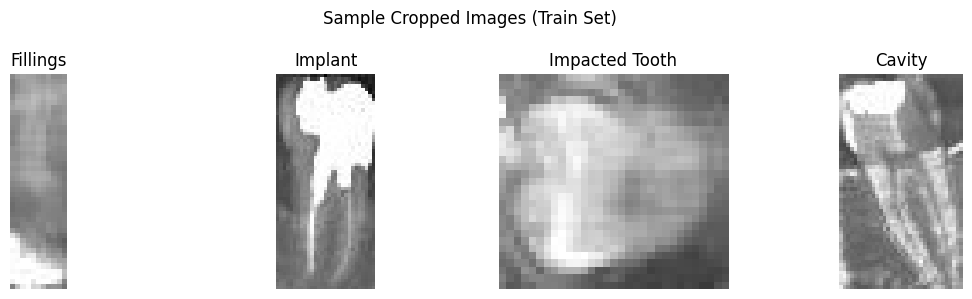

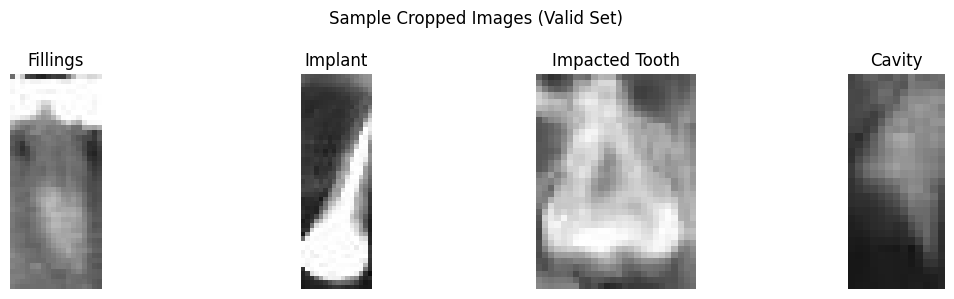

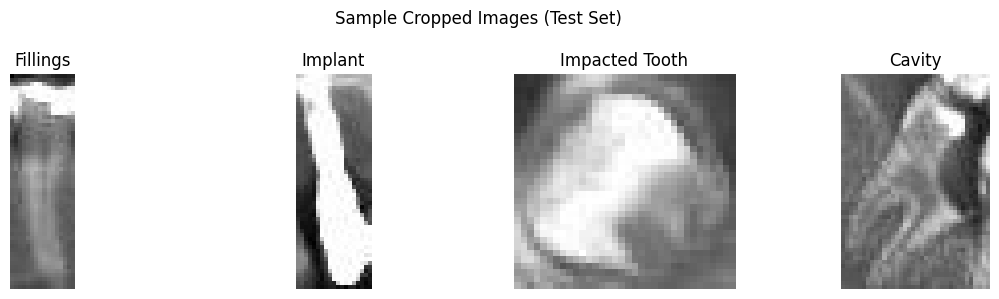

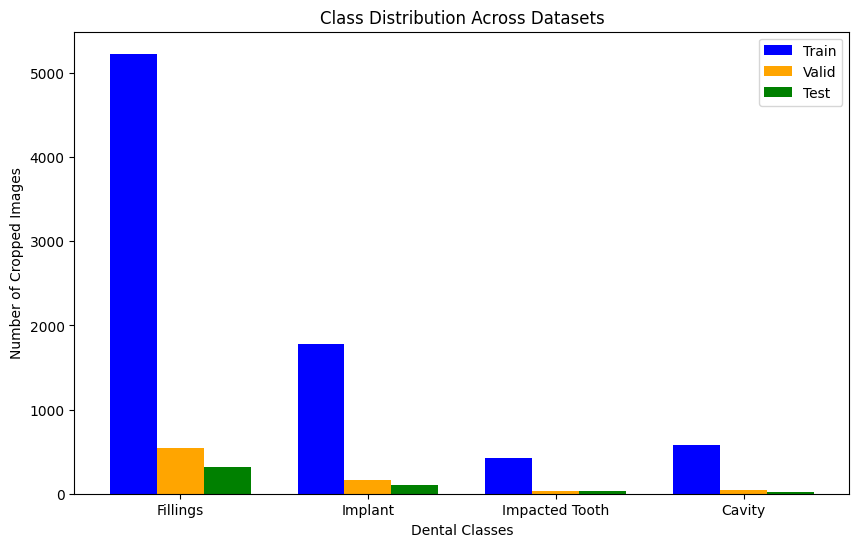

In [11]:
# --- Visualization ---

# 1. Display one sample cropped image per target class from the train set.
for dset_key in class_counts.keys():
    plt.figure(figsize=(12, 3))
    for i, cls in enumerate(target_classes):
        sample_folder = os.path.join(output_root, dset_key, cls)
        sample_files = os.listdir(sample_folder)
        if sample_files:
            sample_path = os.path.join(sample_folder, sample_files[0])
            img = cv2.imread(sample_path)
            if img is not None:
                # Convert BGR (OpenCV default) to RGB for plotting
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, len(target_classes), i+1)
                plt.imshow(img_rgb)
                #plt.title(f"{cls}\n{sample_files[0]}")
                plt.title(f"{cls}")
                plt.axis('off')
    plt.suptitle(f"Sample Cropped Images ({dset_key.capitalize()} Set)")
    plt.tight_layout()
    plt.show()

# 2. Plot class distribution (counts) across train, test, and valid sets.
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(target_classes))
width = 0.25

colors = ['blue', 'orange', 'green', 'red']

# Loop over each dataset key and plot its counts
for i, dset_key in enumerate(class_counts.keys()):
    counts = [class_counts[dset_key][cls] for cls in target_classes]
    # Shift the x positions by width * i
    ax.bar([p + i*width for p in x], counts, width, label=dset_key.capitalize(), color=colors[i % len(colors)])

# Adjust the x-ticks to be in the middle of the grouped bars
num_datasets = len(class_counts.keys())
ax.set_xticks([p + width*(num_datasets-1)/2 for p in x])
ax.set_xticklabels(target_classes)
ax.set_xlabel("Dental Classes")
ax.set_ylabel("Number of Cropped Images")
ax.set_title("Class Distribution Across Datasets")
ax.legend()

plt.show()

Found 8019 images belonging to 4 classes.
Found 779 images belonging to 4 classes.
Found 473 images belonging to 4 classes.

Training DenseNet121...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 175s 533ms/step - accuracy: 0.8013 - loss: 0.5840 - val_accuracy: 0.9320 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 91s 362ms/step - accuracy: 0.9304 - loss: 0.2167 - val_accuracy: 0.9281 - val_loss: 0.2925 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 94s 376ms/step - accuracy: 0.9477 - loss: 0.1676 - val_accuracy: 0.8742 - val_loss: 0.4310 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 92s 367ms/step - accuracy: 0.9588 - loss: 0.1357 - val_accuracy: 0.9448 - val_loss: 0.1848 - learning_rate: 0.0010
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 93s 372ms/step - accuracy: 0.9606 - loss: 0.1251 - val_accuracy: 0.9294 - val_loss: 0.2698 - learning_rate: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 842ms/step - accuracy: 0.9039 - loss: 0.3539
Test accuracy with DenseNet121: 0.9450317025184631
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 843ms/step

Classification Report:
                precision    recall 

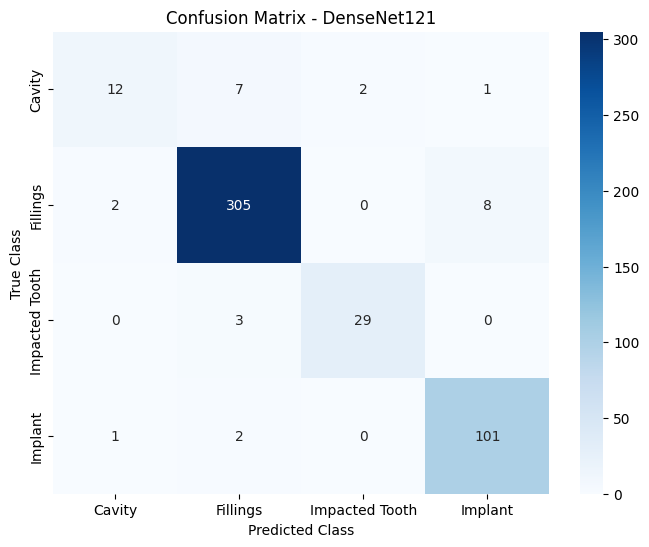

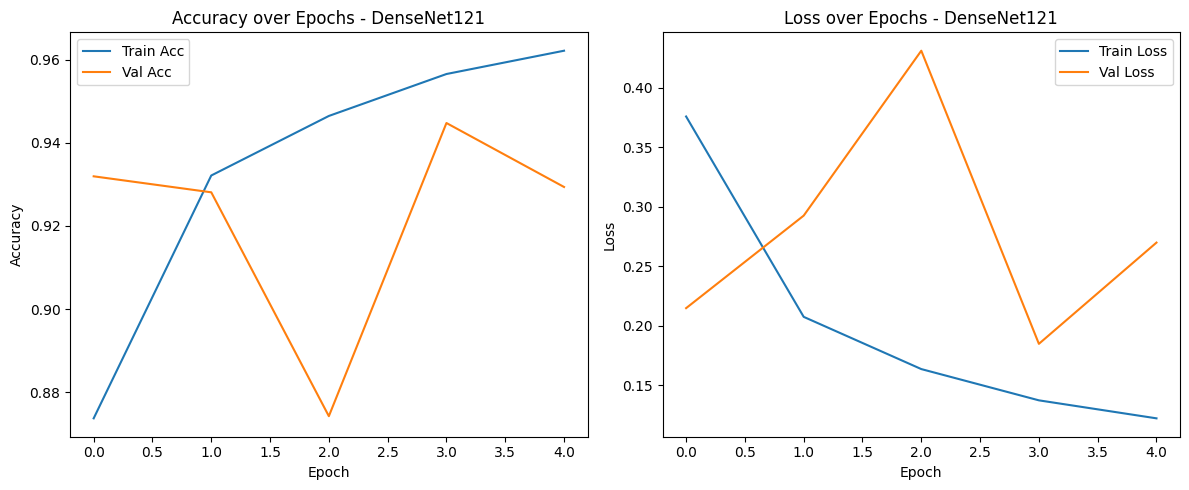


Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 213s 680ms/step - accuracy: 0.6564 - loss: 1.2811 - val_accuracy: 0.8383 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 130s 517ms/step - accuracy: 0.8169 - loss: 0.5765 - val_accuracy: 0.8806 - val_loss: 0.3496 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 523ms/step - accuracy: 0.8572 - loss: 0.4066 - val_accuracy: 0.8909 - val_loss: 0.3228 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 525ms/step - accuracy: 0.8870 - loss: 0.3349 - val_accuracy: 0.9127 - val_loss: 0.2598 - learning_rate: 0.0010
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 520ms/step - accuracy: 0.9091 - loss: 0.2824 - val_accuracy: 0.9255 - val_loss: 0.2213 - learning_rate: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 887ms/step - accuracy: 0.8791 - loss: 0.4187
Test accuracy with VGG16: 0.9281184077262878
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 215m

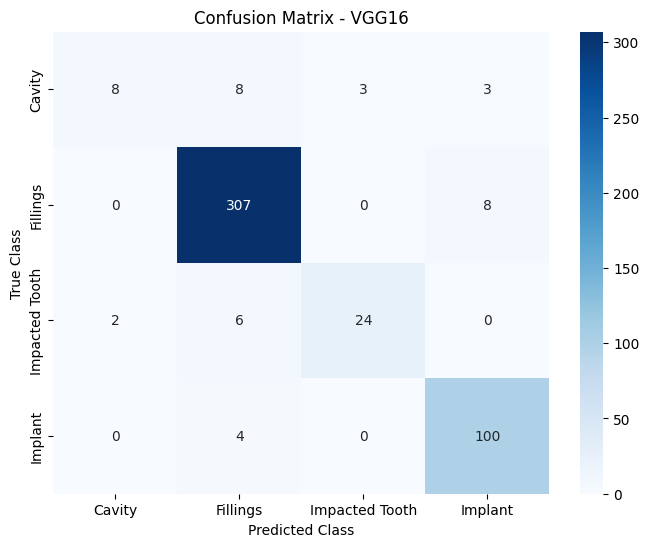

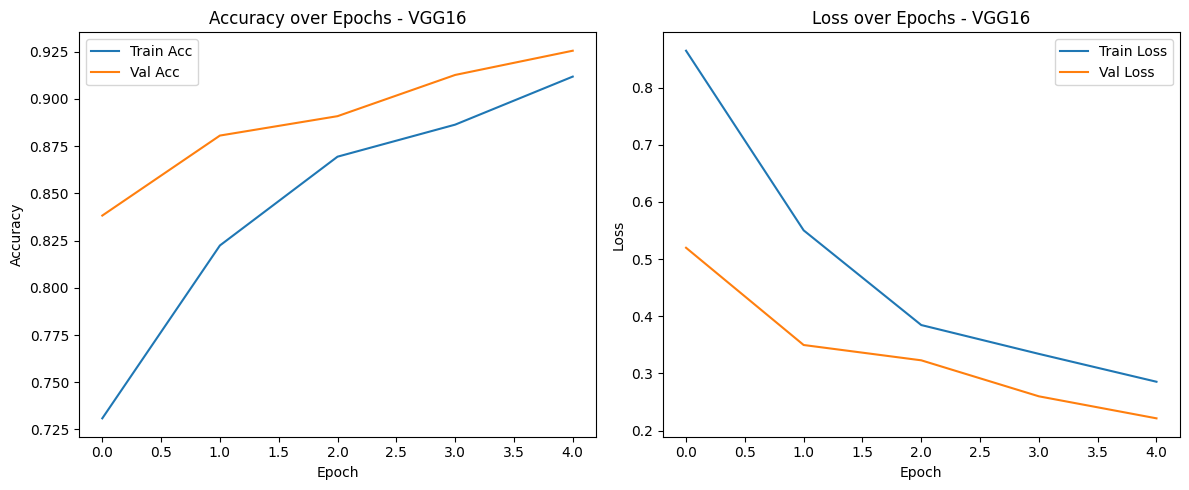


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 145s 470ms/step - accuracy: 0.7319 - loss: 0.8591 - val_accuracy: 0.6919 - val_loss: 192.4228 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 97s 386ms/step - accuracy: 0.8155 - loss: 0.5925 - val_accuracy: 0.6919 - val_loss: 125.9561 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 97s 387ms/step - accuracy: 0.8056 - loss: 0.5665 - val_accuracy: 0.7638 - val_loss: 25.4081 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 97s 387ms/step - accuracy: 0.8215 - loss: 0.5455 - val_accuracy: 0.6919 - val_loss: 31.0638 - learning_rate: 0.0010
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 97s 388ms/step - accuracy: 0.8237 - loss: 0.5410 - val_accuracy: 0.7831 - val_loss: 7.3887 - learning_rate: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8053 - loss: 8.6443
Test accuracy with ResNet50: 0.7780126929283142
15/15 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


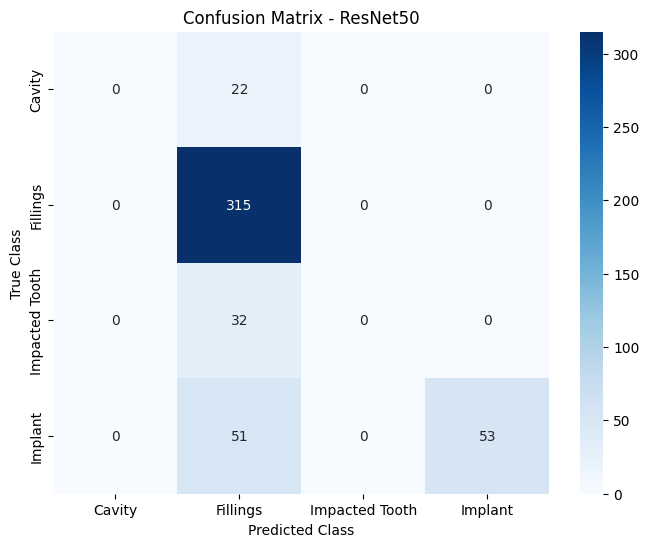

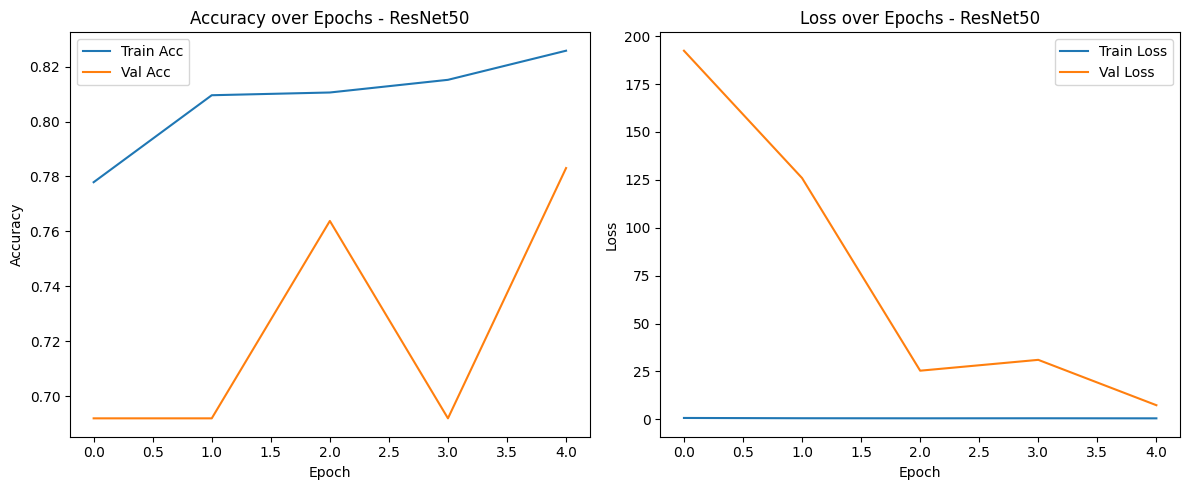


Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 462ms/step - accuracy: 0.8239 - loss: 0.5316 - val_accuracy: 0.8896 - val_loss: 0.3590 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 103s 360ms/step - accuracy: 0.9271 - loss: 0.2326 - val_accuracy: 0.9384 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 93s 369ms/step - accuracy: 0.9517 - loss: 0.1558 - val_accuracy: 0.9371 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 141s 365ms/step - accuracy: 0.9583 - loss: 0.1300 - val_accuracy: 0.9448 - val_loss: 0.2021 - learning_rate: 0.0010
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 94s 375ms/step - accuracy: 0.9596 - loss: 0.1305 - val_accuracy: 0.9422 - val_loss: 0.1828 - learning_rate: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - accuracy: 0.9145 - loss: 0.4111
Test accuracy with InceptionV3: 0.9534883499145508
15/15 ━━━━━━━━━━━━━━━━━━━

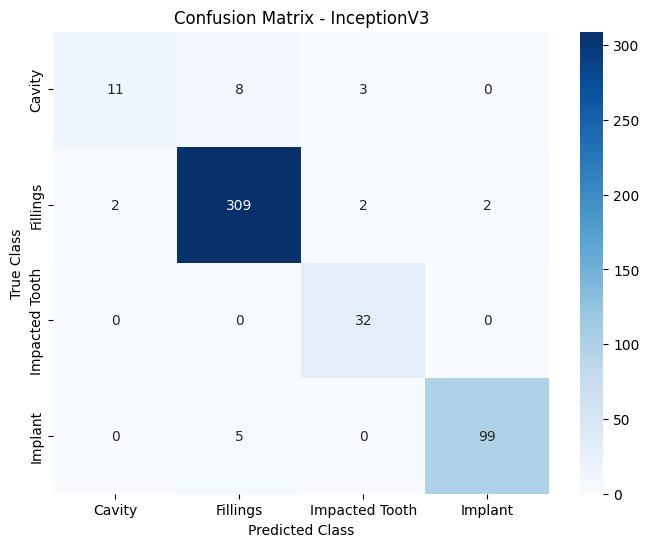

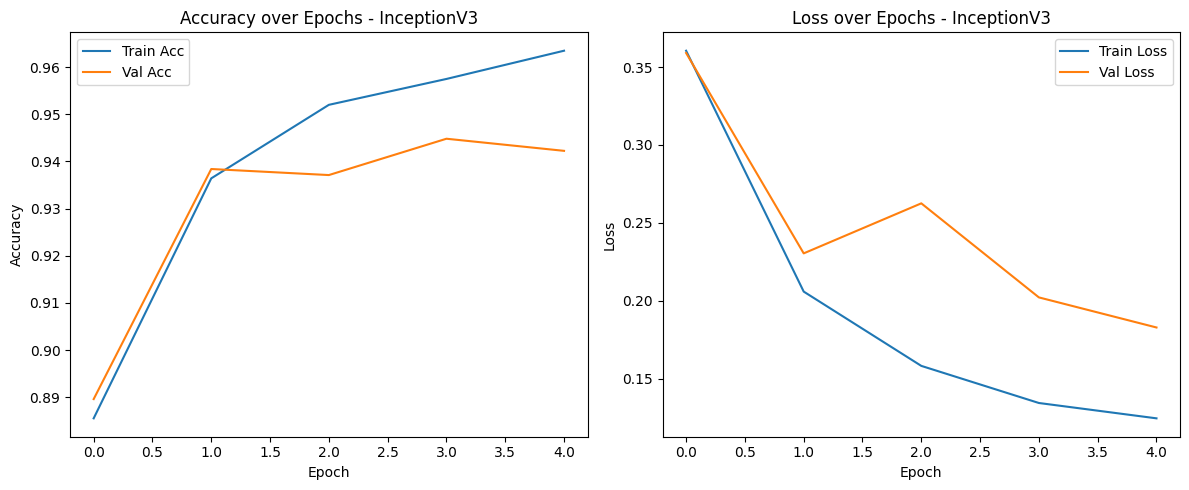


Training MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 125s 408ms/step - accuracy: 0.8611 - loss: 0.4350 - val_accuracy: 0.8498 - val_loss: 1.2239 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 116s 347ms/step - accuracy: 0.9379 - loss: 0.2119 - val_accuracy: 0.3517 - val_loss: 4.9890 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 89s 354ms/step - accuracy: 0.9561 - loss: 0.1456 - val_accuracy: 0.8421 - val_loss: 0.8222 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 90s 357ms/step - accuracy: 0.9616 - loss: 0.1241 - val_accuracy: 0.4634 - val_loss: 4.5455 - learning_rate: 0.0010
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 361ms/step - accuracy: 0.9662 - loss: 0.1106 - val_accuracy: 0.6842 - val_loss: 2.1329 - learning_rate: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.7393 - loss: 1.7258
Test accuracy with MobileNetV2: 0.830866813659668
15/15 ━━━━━━━━━━━━━━━━━━━━ 7

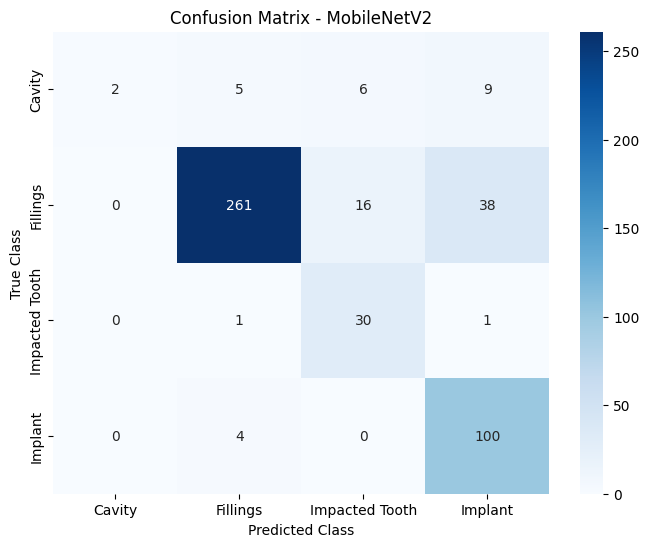

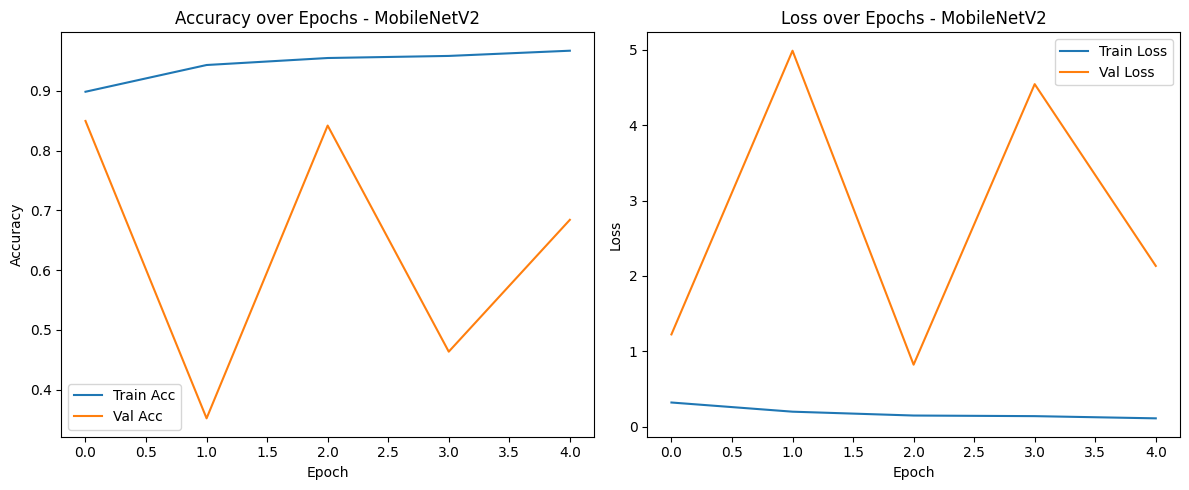


Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 452ms/step - accuracy: 0.6287 - loss: 1.0378 - val_accuracy: 0.6919 - val_loss: 0.9076 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 89s 354ms/step - accuracy: 0.6571 - loss: 0.9824 - val_accuracy: 0.6919 - val_loss: 0.8896 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 90s 359ms/step - accuracy: 0.6498 - loss: 0.9915 - val_accuracy: 0.6919 - val_loss: 0.8918 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 92s 365ms/step - accuracy: 0.6472 - loss: 0.9902 - val_accuracy: 0.6919 - val_loss: 0.8917 - learning_rate: 0.0010
Epoch 5/5


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121,MobileNetV2, EfficientNetB0

# Define key parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Input size for most models
BATCH_SIZE = 32
NUM_EPOCHS = 5

# Directory structure (adjust these paths if needed)
base_dir = '/kaggle/working/cropped'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')

# Data Augmentation for training; rescale for validation/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Create generators from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def create_model(model_type='DenseNet121'):
    if model_type == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif model_type == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif model_type == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif model_type == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif model_type == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif model_type == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    else:
        raise ValueError("Unsupported model type")

    # Freeze all but the last 50 layers
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Define callbacks: early stopping and learning rate reduction on plateau
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# List of models to test
models_to_test = ['DenseNet121', 'VGG16', 'ResNet50', 'InceptionV3','MobileNetV2', 'EfficientNetB0']

# Loop through each model and train, then evaluate
for model_type in models_to_test:
    print(f"\nTraining {model_type}...")
    model = create_model(model_type)

    history = model.fit(
        train_generator,
        epochs=NUM_EPOCHS,
        validation_data=valid_generator,
        callbacks=callbacks
    )

    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy with {model_type}: {test_acc}")

    # Predict on test data (since shuffle is False, the order aligns with test_generator.classes)
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Compute and display confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix - {model_type}')
    plt.show()

    # Plot training and validation accuracy and loss
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over Epochs - {model_type}')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over Epochs - {model_type}')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()
